# 基于梯度下降的线性回归模型

本文主要介绍了使用梯度下降方法实现的线性回归模型，并且可视化了模型训练过程

## 主要使用的公式

首先定义和推导一些需要使用到的主要公式

- hypothesis function

\begin{equation} 
h_\theta(x) = \theta_0 + \theta_1x_1 + ... + \theta_nx_n
\end{equation}

- cost function

\begin{equation}
J(\theta) = \frac{1}{2m}\displaystyle\sum_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^{2}
\end{equation}

- 权重梯度

\begin{equation}
\frac{\partial}{\partial\theta_n}J(\theta) = \frac{1}{m}\displaystyle\sum_{i=1}^{m}(h_\theta(x^{i}) - y^{(i)})x_n^{(i)}
\end{equation}

其中，用于偏置计算的$x_0^{(i)}$的是为1的向量

- 权重更新

\begin{align}
\theta_n &= \theta_n - \alpha\frac{\partial}{\partial\theta_n}J(\theta) \\
&= \theta_n - \alpha\frac{1}{m}\displaystyle\sum_{i=1}^{m}(h_\theta(x^{i}) - y^{(i)})x_n^{(i)}
\end{align}

## 线性回归模型实现

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LinearRegressionGD:
    def __init__(self, learning_rate=1e-3, n_iter=50, record_weights=False):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.record_weights = record_weights
        if record_weights:
            self.recorded_weights = []
        
        self.costs = []
        
    def fit(self, X, y):
        # 增加一列全为1的向量，用于更新偏置
        bias_X = np.column_stack((np.ones(X.shape[0]), X))
        # 随机初始化权重
        self.weights = np.random.normal(scale=0.05, size=bias_X.shape[1])
        for i in range(self.n_iter):
            outputs = self.__cal_output(bias_X)
            errors = outputs - y
            
            cost = self.__cal_cost(errors)
            self.costs.append(cost)
            
            # 更新权重(公式4)
            self.weights = self.weights - self.learning_rate * self.__cal_weights_gradient(bias_X, errors)
            if self.record_weights:
                self.recorded_weights.append(np.copy(self.weights))

        if self.record_weights:
            self.recorded_weights = np.array(self.recorded_weights)
    
    # 计算模型输出(公式1)
    def __cal_output(self, X):
        return np.dot(X, self.weights)

    # 计算cost(公式2)
    def __cal_cost(self, errors):
        return np.square(errors).sum() / (2 * len(errors))
    
    # 计算权重梯度(公式3)
    def __cal_weights_gradient(self, X, errors):
        return np.dot(X.T, errors) / len(errors)
    
    def get_weights(self):
        return {'bias': self.weights[0], 'weights': self.weights[1:]}
    
    def predict(self, X):
        bias_X = np.column_stack((np.ones(X.shape[0]), X))
        return self.__cal_output(bias_X)
    
    # 绘制cost下降情况
    def plot_cost(self, start=0, end=None, max_cost=None):
        # 由于初始时的cost非常大，因此可以设定一个max_cost，只展示此cost以下的情况，便于观察cost下降
        if max_cost:
            plot_cost = [cost for cost in self.costs if cost <= max_cost]
        else:
            plot_cost = self.costs[start:end]
        plt.plot(plot_cost)
        plt.xlabel('iter', fontsize=15)
        plt.ylabel('cost', fontsize=15)
        plt.show()

## 训练模型

- 生成模拟数据

根据如下函数产生模拟数据  
$y = 4 + x_0 + 2x_1 + 3x_2 + \varepsilon$, 其中$\varepsilon \sim N(0, 1)$  

In [3]:
X = np.random.randn(500, 3)
y = np.apply_along_axis(lambda x: x[0] + x[1] * 2 + x[2] * 3 + 4 , 1, X) + np.random.randn(500)

- 训练模型

In [4]:
lr = LinearRegressionGD(learning_rate=0.001, n_iter=5000)

lr.fit(X, y)

- 查看回归的权重

In [5]:
lr.get_weights()

{'bias': 4.010246483208005,
 'weights': array([1.02098505, 1.92862272, 3.01389998])}

模型的权重非常接近模拟生成数据的公式

- 查看cost变化情况

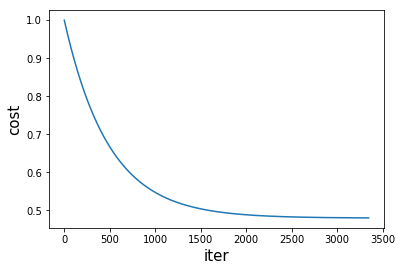

In [6]:
lr.plot_cost(max_cost=1)

## 可视化模型训练过程

- 生成模拟数据

定义一个只有一个变量的模拟数据，这样可以方便可视化梯度下降

In [7]:
from matplotlib import cm

In [8]:
X = np.random.randn(100, 1)
y = 2 + 2 * X.flatten() + np.random.randn(100)

In [9]:
lr = LinearRegressionGD(n_iter=5000, record_weights=True)

lr.fit(X, y)

In [10]:
lr.get_weights()

{'bias': 1.933311453502482, 'weights': array([1.81243744])}

- 绘制回归线变化

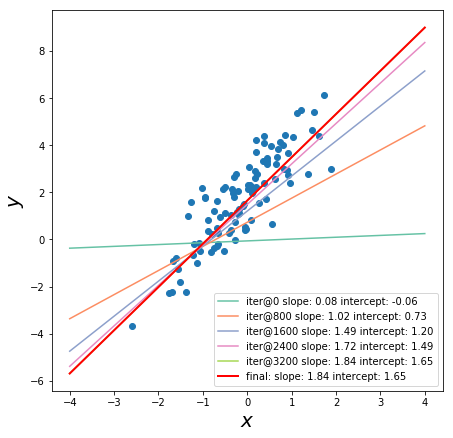

In [11]:
fig = plt.figure(figsize=(7, 7))
plt.scatter(X, y)
x = np.linspace(-4, 4, 10)
plot_weight_index = [0, 500, ]
cmap = cm.get_cmap('Set2')
for c_ind, w_ind in enumerate(range(0, 4000, 800)):
    slope, intercept = lr.recorded_weights[w_ind, :]
    line = slope * x + intercept
    plt.plot(x, line, color=cmap(c_ind), label='iter@%d slope: %.2f intercept: %.2f' % (w_ind, slope, intercept))
final_sploe, final_intercept = lr.get_weights()
line = slope * x + intercept
plt.plot(x, line, color='r', linewidth=2, label='final: slope: %.2f intercept: %.2f' % (slope, intercept))
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
plt.legend(loc='lower right')
plt.show()

- 绘制权重的在cost图中的移动路径

In [12]:
# 根据特定参数计算cost
def cal_costs(theta0, theta1, X, y):
    X_ = np.column_stack((np.ones(X.shape[0]), X))
    errors = np.dot(X_, np.array([theta0, theta1])) - y
    return np.square(errors).sum() / (2 * len(errors))

In [13]:
x_range = np.linspace(-0.5, 3.5, num=200)
y_range = np.linspace(-0.5, 3.5, num=200)
xv, yv = np.meshgrid(x_range, y_range)
costs = []
for x_ in np.array([xv.flatten(), yv.flatten()]).T:
    cost = cal_costs(x_[0], x_[1], X, y)
    costs.append(cost)

costs = np.array(costs).reshape(xv.shape)
weights = lr.recorded_weights

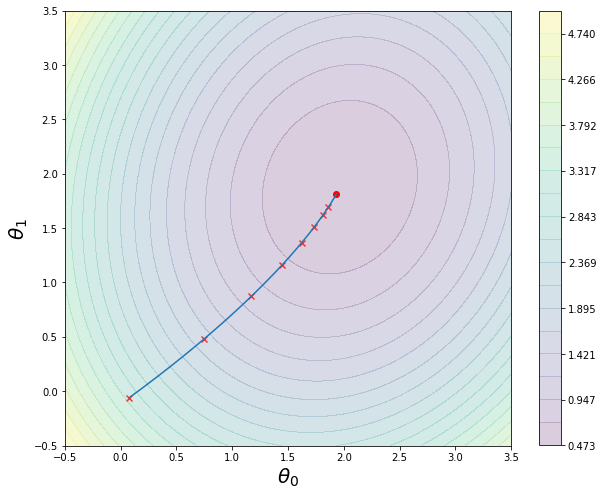

In [14]:
fig = plt.figure(figsize=(10, 8))
my_levels=np.linspace(np.min(costs), np.max(costs), 20)
cs = plt.contourf(xv, yv, costs, alpha=0.2, cmap=cm.viridis, levels=my_levels)
cbar = fig.colorbar(cs)
plt.plot(weights[:, 0], weights[:, 1])
plt.scatter(weights[:, 0][:4000:500], weights[:, 1][:4000:500],
            marker='x', color='red', alpha=0.75)
plt.scatter(weights[-1, 0], weights[-1, 1], marker='o', color='red')
plt.xlabel(r'$\theta_0$', fontsize=20)
plt.ylabel(r'$\theta_1$', fontsize=20)
plt.show()